# read in data

In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split
df = pd.read_csv('mercari-price-suggestion-challenge/train.tsv', sep='\t')
df_train, df_test = train_test_split(df)

In [43]:
df_train.shape, df_test.shape

((1111901, 8), (370634, 8))

In [44]:
df_train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
1323343,1323343,FAST FREE SHIP Love pink lanyard,1,Handmade/Accessories/Lanyard,NaN,6.0,1,This lanyard fits comfortably around the neck ...
1130463,1130463,Disney Aladdin Blu Ray Disc ONLY,2,Electronics/Media/Blu-Ray,NaN,6.0,1,Perfect condition Disney Aladdin Blu Ray Disc ...
1429519,1429519,Cleansing detox foot pads,1,Other/Daily & Travel items/Health Care,NaN,16.0,1,New 3 packs.
29219,29219,"FLAWLESS iPhone 6 , Verizon 16GB",2,Electronics/Cell Phones & Accessories/Cell Pho...,Apple,200.0,1,"Only used this phone for about 8 months, basic..."
545342,545342,Womens sz xl / 16 lot dresses top skirts,3,Women/Dresses/Knee-Length,NaN,50.0,1,8 dresses. 3 skirts. 1 top.


In [45]:
df_train.describe(include='all')

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
count,1.111901e+06,1111901,1.111901e+06,1107111,637123,1.111901e+06,1.111901e+06,1111897
unique,NaN,936651,NaN,1266,4450,NaN,NaN,967793
top,NaN,Bundle,NaN,"Women/Athletic Apparel/Pants, Tights, Leggings",PINK,NaN,NaN,No description yet
freq,NaN,1715,NaN,45126,40599,NaN,NaN,61890
mean,7.411639e+05,NaN,1.907733e+00,NaN,NaN,2.674282e+01,4.471270e-01,NaN
std,4.280626e+05,NaN,9.032344e-01,NaN,NaN,3.864513e+01,4.971968e-01,NaN
min,0.000000e+00,NaN,1.000000e+00,NaN,NaN,0.000000e+00,0.000000e+00,NaN
25%,3.702290e+05,NaN,1.000000e+00,NaN,NaN,1.000000e+01,0.000000e+00,NaN
50%,7.414630e+05,NaN,2.000000e+00,NaN,NaN,1.700000e+01,0.000000e+00,NaN
75%,1.111936e+06,NaN,3.000000e+00,NaN,NaN,2.900000e+01,1.000000e+00,NaN


In [46]:
import keras

def preprocess(df):
    category_ids = {v: i for i, v in enumerate(df.category_name.unique(), start=1)}
    brand_ids = {v: i for i, v in enumerate(df.brand_name.unique(), start=1)}
    df['category_id'] = df.category_name.map(category_ids)
    df['brand_id'] = df.brand_name.map(brand_ids)
    
    df[['category_id', 'brand_id', 'item_condition_id']].fillna(0, inplace=True)
    df['text'] = df.name + ' ' + df.item_description.str.replace('No description yet', '')
    df['text'] = df.text.astype(str)
    
    return df

df_train = preprocess(df_train)
df_test = preprocess(df_test)

/Users/dgates/venvs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/dgates/venvs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/dgates/venvs/py3/lib/python3.6/site-packages/pandas/core/frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

In [47]:
df_train.text.str.count(' ').describe()

count    1.111901e+06
mean     2.895952e+01
std      3.085213e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.900000e+01
75%      3.500000e+01
max      2.510000e+02
Name: text, dtype: float64

In [48]:
df_train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_id,brand_id,text
1323343,1323343,FAST FREE SHIP Love pink lanyard,1,Handmade/Accessories/Lanyard,NaN,6.0,1,This lanyard fits comfortably around the neck ...,1,1,FAST FREE SHIP Love pink lanyard This lanyard ...
1130463,1130463,Disney Aladdin Blu Ray Disc ONLY,2,Electronics/Media/Blu-Ray,NaN,6.0,1,Perfect condition Disney Aladdin Blu Ray Disc ...,2,1,Disney Aladdin Blu Ray Disc ONLY Perfect condi...
1429519,1429519,Cleansing detox foot pads,1,Other/Daily & Travel items/Health Care,NaN,16.0,1,New 3 packs.,3,1,Cleansing detox foot pads New 3 packs.
29219,29219,"FLAWLESS iPhone 6 , Verizon 16GB",2,Electronics/Cell Phones & Accessories/Cell Pho...,Apple,200.0,1,"Only used this phone for about 8 months, basic...",4,2,"FLAWLESS iPhone 6 , Verizon 16GB Only used thi..."
545342,545342,Womens sz xl / 16 lot dresses top skirts,3,Women/Dresses/Knee-Length,NaN,50.0,1,8 dresses. 3 skirts. 1 top.,5,1,Womens sz xl / 16 lot dresses top skirts 8 dre...


# build byte pair encoder

In [8]:
%load_ext Cython

In [9]:
class Node:
    def __init__(self, parent=None):
        self.parent = parent
        self.children = {}
        self.index = None

    def __repr__(self):
        return f'Node(index={self.index}, children={self.children})'
    
    def get(self, key, default=None):
        return self.children.get(key, default)
    
    def __getitem__(self, key):
        return self.children[key]
    
    def __setitem__(self, key, value):
        self.children[key] = value
        
    def __contains__(self, key):
        return key in self.children


def build_bpe_tree(vocab):
    root = Node()
    for word, index in vocab.items():
        current_node = root
        for n, c in enumerate(word, start=1):
            if not c in current_node:
                current_node[c] = Node()
            current_node = current_node[c]
            if n == len(word):
                current_node.index = index
    return root


def apply_bpe_tree(text, tree):
    output = []
    pos = 0
    last_node = tree
    while pos <= len(text) - 1:
        node = last_node.get(text[pos])
        # we can't search the tree any further
        if node is None:
            # we couldn't search the tree any further but we
            # ended up at a node that doesn't correspond to a
            # word in the learned vocabulary.
            # In this case we'll traverse back through the tree
            # until we hit a node with an index.
            if last_node.index is None:
                while last_node.index is not None:
                    last_node = last_node.parent
                    pos -= 1
            # add the last seen index to the output
            # and reset variables for next run through
            output.append(last_node.index)
            if last_node is not tree:
                last_node = tree
                continue
            node = tree
        last_node = node
        pos += 1
    output.append(last_node.index)
    return output


In [10]:
%%cython
def get_stats(list vocab):
    cdef c1, c2
    cdef list word
    cdef int freq, vocab_pos, word_pos
    cdef dict pair_stats = {}
    cdef dict pair_indices = {}
    cdef tuple pair
    for vocab_pos in range(len(vocab)):
        word, freq = vocab[vocab_pos]
        for word_pos in range(len(word) - 1):
            pair = word[word_pos], word[word_pos + 1]
            if not pair in pair_stats:
                pair_stats[pair] = 0
            pair_stats[pair] += freq
            if not pair in pair_indices:
                pair_indices[pair] = []
            pair_indices[pair].append((vocab_pos, word_pos))
    return pair_stats, pair_indices


def merge_vocab(tuple pair, list vocab, list pair_indices):
    cdef int vocab_pos, word_pos
    cdef list word
    for vocab_pos, word_pos in reversed(pair_indices):
        word, _ = vocab[vocab_pos]
        word[word_pos] = word[word_pos] + word[word_pos + 1]
        word.pop(word_pos + 1)
    return vocab


In [11]:
import collections
import time

import sklearn
import numpy as np


class BytePairEncoder(sklearn.base.TransformerMixin):    
    _unkown_character = '<unk>'
    _space_escape = '▁'

    def __init__(self, target_vocab_size, vocab_threshold=None, log_level=None):
        self.target_vocab_size = target_vocab_size
        self.log_level = log_level
        self.vocab_threshold = vocab_threshold

        # these will all be set during .fit()
        self.vocab = None
        self._vocab_stats = None
        self._reverse_vocab = None
        self._bpe_tree = None

    def fit(self, X):
        # get the initial vocabular consisting of all unique characters
        initial_vocab = set(X)
        initial_vocab.add(self._space_escape)

        words = self._split_X(X)
        vocab = [(list(word), freq) for word, freq in collections.Counter(words).items()]

        t_started = time.time()
        i = 0
        while self._vocab_size(vocab) < self.target_vocab_size:
            if self.log_level is not None \
                    and i and (i + 1) % self.log_level == 0:
                print(f'{i+1} iterations complete in {time.time() - t_started}')
            pair_stats, pair_index = get_stats(vocab)
            best = max(pair_stats, key=pair_stats.get)
            if self.vocab_threshold is not None \
                    and pair_stats[best] < self.vocab_threshold:
                print(f'Stopping after {i} iterations. Best pair occurs '
                      f'{pair_stats[best]} < {self.vocab_threshold} times')
                break
            vocab = merge_vocab(best, vocab, pair_index[best])
            i += 1

        # build the final vocabulary
        vocab_stats = collections.Counter()
        _ = [vocab_stats.update({subword: freq})
                                for word, freq in vocab
                                for subword in word]
        final_vocab = set(vocab_stats)
        final_vocab.update(initial_vocab)
        final_vocab = {k: i for i, k in enumerate(final_vocab, start=1)}
        final_vocab[self._unkown_character] = 0
        self.vocab = final_vocab

        # these are needed for .transform() and .inverse_transform()
        self._reverse_vocab = {i: k for k, i in self.vocab.items()}
        self._bpe_tree = build_bpe_tree(self.vocab)

        # keep this for curiosity/debugging
        self._vocab_stats = vocab_stats

    def transform(self, X):
        X = self._split_X(X)
        return np.concatenate([self._transform_string(x) for x in X])

    def _transform_string(self, X):
        tokens = apply_bpe_tree(X, self._bpe_tree)
        return np.array([0 if t is None else t for t in tokens])                

    def inverse_transform(self, X):
        return [self._reverse_vocab[t] for t in X]

    def _split_X(self, X):
        return [word + self._space_escape for word in X.split()]

    def _vocab_size(self, vocab):
        return len(set(subword for word, _ in vocab for subword in word))


In [12]:
bpe_text = ' '.join(df_train.item_description.sample(30000))
bpe_text[:150]

'Hollister jean shorts, SIZE 9. Great condition. prices are NOT firm check my closet and save on bundles F21 (M) thigh length knitted New with tag No B'

In [13]:
len(bpe_text)

4416571

In [14]:
bpe = BytePairEncoder(30000, log_level=1000, vocab_threshold=5)
%time bpe.fit(bpe_text.lower())

1001 iterations complete in 262.1924641132355
2001 iterations complete in 510.85629892349243
3001 iterations complete in 765.7708230018616
4001 iterations complete in 1002.2984910011292
5001 iterations complete in 1247.4365611076355
6001 iterations complete in 1493.677533864975
7001 iterations complete in 1748.0518581867218
8001 iterations complete in 1978.9800019264221
9001 iterations complete in 2218.366352081299
10001 iterations complete in 2434.7551760673523
11001 iterations complete in 2643.507613182068
12001 iterations complete in 2842.9302089214325
13001 iterations complete in 3038.519464969635
14001 iterations complete in 3230.526780128479
15001 iterations complete in 3419.908914089203
16001 iterations complete in 3605.580456972122
17001 iterations complete in 3788.129462957382
18001 iterations complete in 3966.83597612381
Stopping after 18771 iterations. Best pair occurs 4 < 5 times
CPU times: user 1h 7min 24s, sys: 35.4 s, total: 1h 8min
Wall time: 1h 8min 22s


In [15]:
len(bpe.vocab)

18814

In [16]:
bpe.vocab

{'photos▁': 1,
 'sky': 2,
 'a14': 3,
 'towel.▁': 4,
 'photos,▁': 5,
 'generation▁': 6,
 'oce': 7,
 'insp': 8,
 'acc': 9,
 '⌛': 10,
 'nur': 11,
 'available,▁': 12,
 '2/': 13,
 'latex': 14,
 'fric': 15,
 'flare▁': 16,
 '2pc▁': 17,
 'pockets.▁': 18,
 'shampoo,▁': 19,
 'twin▁': 20,
 'cambogia▁': 21,
 'big': 22,
 '3-': 23,
 'approved!▁': 24,
 'cut.▁': 25,
 'clin': 26,
 'elmers▁': 27,
 'liber': 28,
 'rage▁': 29,
 '16-': 30,
 'rap▁': 31,
 '(as▁': 32,
 'negotiate!▁': 33,
 'digital▁': 34,
 'ats▁': 35,
 'ovals▁': 36,
 'germany▁': 37,
 'bowl▁': 38,
 'wave▁': 39,
 'cord,▁': 40,
 'cigare': 41,
 'calls▁': 42,
 'heel': 43,
 'appe': 44,
 '38d▁': 45,
 'batter': 46,
 'age': 47,
 'shooting▁': 48,
 'ped,▁': 49,
 'innov': 50,
 'team▁': 51,
 'eyebrows▁': 52,
 'pulled▁': 53,
 'bnib▁': 54,
 'vines,▁': 55,
 'straps.▁': 56,
 'gopro▁': 57,
 'gk▁': 58,
 '1.7▁': 59,
 'blood▁': 60,
 'authenticity▁': 61,
 'pted▁': 62,
 'peeling▁': 63,
 'chero': 64,
 '☀': 65,
 '¤▁': 66,
 'geometr': 67,
 'headphone▁': 68,
 'copper▁': 

In [17]:
bpe._vocab_stats['92%▁']

19

In [35]:
import joblib
joblib.dump(bpe, 'byte-pair-encoder.pkl')

['byte-pair-encoder.pkl']

# encode/decode some strings

## performance

In [18]:
len(bpe_text)

4416571

In [19]:
%time tokens = bpe.transform(bpe_text.lower())

CPU times: user 4.67 s, sys: 69.8 ms, total: 4.74 s
Wall time: 4.74 s


In [20]:
%time bpe.inverse_transform(tokens)

CPU times: user 282 ms, sys: 6.55 ms, total: 289 ms
Wall time: 289 ms


['hollister▁',
 'jean▁',
 'shorts,▁',
 'size▁',
 '9.▁',
 'great▁',
 'condition.▁',
 'prices▁',
 'are▁',
 'not▁',
 'firm▁',
 'check▁',
 'my▁',
 'closet▁',
 'and▁',
 'save▁',
 'on▁',
 'bundles▁',
 'f21▁',
 '(m)▁',
 'thigh▁',
 'length▁',
 'knitted▁',
 'new▁',
 'with▁',
 'tag▁',
 'no▁',
 'bound',
 '<unk>',
 's▁',
 'christmas▁',
 'leggings▁',
 'santa▁',
 'size▁',
 'medium▁',
 '7-',
 '9▁',
 'super▁',
 'cute▁',
 'but▁',
 'not▁',
 'love▁',
 'on▁',
 'me▁',
 ':(▁',
 'brand▁',
 'new▁',
 'lularoe▁',
 'tc▁',
 'bear▁',
 'leggings▁',
 'with▁',
 'a▁',
 'black▁',
 'background.▁',
 'please▁',
 'note▁',
 'that▁',
 'i▁',
 'do▁',
 'not▁',
 'have▁',
 'original▁',
 'packaging▁',
 'but▁',
 'these▁',
 'have▁',
 'never▁',
 'been▁',
 'worn▁',
 'nor▁',
 'washed.▁',
 'check▁',
 'out▁',
 'my▁',
 'other▁',
 'listings!▁',
 'in▁',
 'great▁',
 'condition!▁',
 'worn▁',
 'only▁',
 'a▁',
 'few▁',
 'times▁',
 'brand▁',
 'new▁',
 'one▁',
 'taupe',
 ',▁',
 'one▁',
 'dark▁',
 'olive.▁',
 'adjustable▁',
 'neck▁',
 'and▁',
 'ba

## look at encodings on subset

In [21]:
t = bpe_text[:100].lower()
t

'hollister jean shorts, size 9. great condition. prices are not firm check my closet and save on bund'

In [22]:
%time tokens = bpe.transform(t)
tokens

CPU times: user 189 µs, sys: 772 µs, total: 961 µs
Wall time: 942 µs


array([ 5145, 15787,  4635,  2916,  1313,  5339,  7863, 14890, 16978,
         761, 17894,  5248, 12414, 12835, 14416, 17428, 15183, 12793,
       14203])

In [23]:
inv_tokens = bpe.inverse_transform(tokens)
inv_tokens

['hollister▁',
 'jean▁',
 'shorts,▁',
 'size▁',
 '9.▁',
 'great▁',
 'condition.▁',
 'prices▁',
 'are▁',
 'not▁',
 'firm▁',
 'check▁',
 'my▁',
 'closet▁',
 'and▁',
 'save▁',
 'on▁',
 'bund',
 '▁']

# build model

## create inputs

In [69]:
from keras.preprocessing.sequence import pad_sequences


def make_Xy(df, tokens_per_batch, max_batch_size):
    df['text_tokens'] = df.text.apply(bpe.transform)
    df['n_text_tokens'] = df.text_tokens.apply(len)
    df.sort_values('n_text_tokens', inplace=True)
    df['batch'] = df.n_text_tokens.cumsum() % tokens_per_batch
    def gen():
        while True:
            for b in df.batch:
                batch = df[df.batch == b]
                batch = batch.sample(frac=1)
                for i in range(len(batch) // max_batch_size):
                    batch_chunk = batch.iloc[i*max_batch_size:(i+1)*max_batch_size]
                    maxlen = batch_chunk.n_text_tokens.max()
                    X = {
                        'category_input': batch_chunk.category_id,
                        'brand_input': batch_chunk.brand_id,
                        'item_condition_input': batch_chunk.item_condition_id,
                        'text_input': pad_sequences(batch_chunk.text_tokens, maxlen=maxlen),
                        'shipping_input': batch_chunk.shipping
                    }
                    y = batch_chunk.price
                    yield X, y
    return df, gen, df.batch.nunique()


In [70]:
df_train, Xy_train_gen, train_batches = make_Xy(df_train, 64*32, 100)
df_test, Xy_test_gen, test_batches = make_Xy(df_test, 64*32, 100)

## build and train model

In [73]:
category_input = keras.layers.Input(shape=(1,), name='category_input')
brand_input = keras.layers.Input(shape=(1,), name='brand_input')
item_condition_input = keras.layers.Input(shape=(1,), name='item_condition_input')
text_input = keras.layers.Input(shape=(None,), name='text_input')
shipping_input = keras.layers.Input(shape=(1,), name='shipping_input')
inputs = [category_input, brand_input, item_condition_input, text_input, shipping_input]

# categorical feature embeddings
category_embedding = keras.layers.Embedding(
    input_dim=df_train.category_id.nunique()+1,
    output_dim=5, input_length=1)(category_input)

brand_embedding = keras.layers.Embedding(
    input_dim=df_train.brand_id.nunique()+1,
    output_dim=5, input_length=1)(brand_input)

item_condition_embedding = keras.layers.Embedding(
    input_dim=df_train.item_condition_id.nunique()+1,
    output_dim=5, input_length=1)(item_condition_input)

embedding_tensors = [category_embedding, brand_embedding, item_condition_embedding]
x_embeddings = keras.layers.Concatenate()([
    keras.layers.Flatten()(embedding) for embedding in embedding_tensors
])

shipping_input = keras.layers.BatchNormalization()(shipping_input)


# text features
import keras.backend as K
Sum = keras.layers.Lambda(lambda x: K.sum(x, axis=1))

def SelfAttention(X):
    dim = K.int_shape(X)[-1]
    q = keras.layers.Dense(dim)(X)
    q = keras.layers.Dropout(0.1)(q)    
    k = keras.layers.Dense(dim)(X)
    k = keras.layers.Dropout(0.1)(k)
    v = keras.layers.Dense(dim)(X)
    v = keras.layers.Dropout(0.1)(v)
    w = keras.layers.Dot((2, 2))([q, k])
    w = keras.layers.Softmax(axis=1)(w)
    return keras.layers.Dot((2, 1))([w, v])
    

text_embeddings = keras.layers.Embedding(
    input_dim=len(bpe.vocab)+1, output_dim=10, input_length=None)(text_input)
text_embeddings = keras.layers.SpatialDropout1D(0.4)(text_embeddings)
attention = SelfAttention(text_embeddings)
x_text = Sum(attention)


x = keras.layers.Concatenate()([x_embeddings, x_text, shipping_input])
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(K.int_shape(x)[-1], activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(1, activation='relu')(x)

model = keras.models.Model(inputs=inputs, outputs=x)

In [74]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         (None, None)         0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, None, 10)     188150      text_input[0][0]                 
__________________________________________________________________________________________________
spatial_dropout1d_3 (SpatialDro (None, None, 10)     0           embedding_12[0][0]               
__________________________________________________________________________________________________
dense_11 (Dense)                (None, None, 10)     110         spatial_dropout1d_3[0][0]        
__________________________________________________________________________________________________
dense_12 (

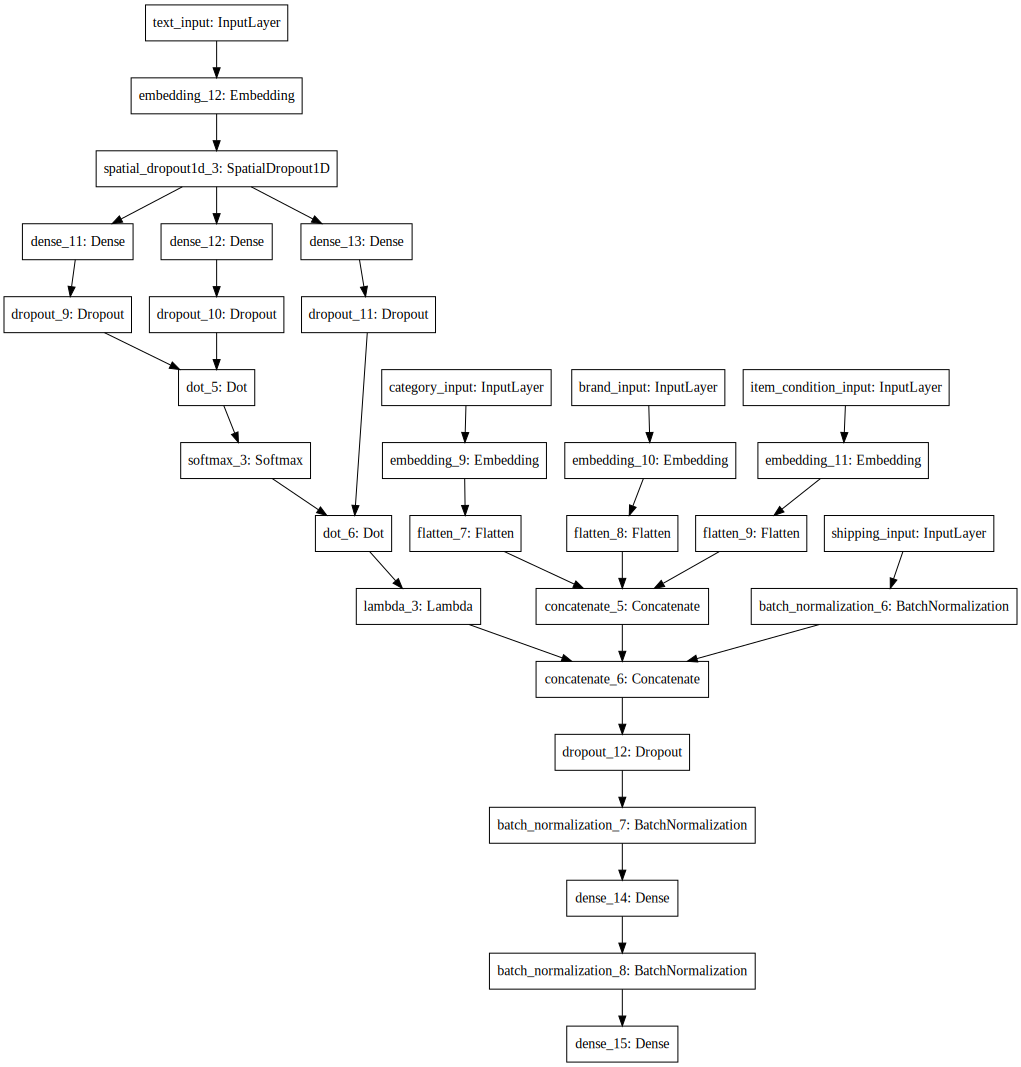

In [75]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [76]:
def rmsle(y_true, y_pred):
    return K.sqrt(K.mean(K.square(K.log(y_pred+1.) - K.log(y_true+1.))))
model.compile(loss=rmsle, optimizer='adam')

In [ ]:
model.fit_generator(
    Xy_train_gen(),
    epochs=10,
    steps_per_epoch=train_batches,
    validation_data=Xy_test_gen(),
    validation_steps=test_batches,
    callbacks=[keras.callbacks.ReduceLROnPlateau(patience=2),
               keras.callbacks.EarlyStopping(patience=3),
               keras.callbacks.TerminateOnNaN()]
)

Epoch 1/10
2048/2048 [==============================] - 1822s 890ms/step - loss: 0.9499 - val_loss: 0.8468
Epoch 2/10
2048/2048 [==============================] - 1779s 869ms/step - loss: 0.5889 - val_loss: 0.8321
Epoch 3/10
2048/2048 [==============================] - 1773s 866ms/step - loss: 0.5629 - val_loss: 0.8076
Epoch 4/10
2048/2048 [==============================] - 1832s 894ms/step - loss: 0.5505 - val_loss: 0.7671
Epoch 5/10
1406/2048 [===================>..........] - ETA: 8:03 - loss: 0.5462